In [11]:
import math


class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [13]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [20]:
w =  [
[ 0.2963, 1.1951, 0.7433],
[ 2.6439, 1.7843, 0.2086], 
[-0.6386, 0.2266, -0.0906]
]

x = [1,0,0]

In [21]:
import numpy as np

# inputs x1,x2
x = [Value(v, label=f"x{i}") for i,v in enumerate(x)]
w = [[Value(weight, label=f"x{row}{col}")  for col,weight in enumerate(weights)] for row,weights in enumerate(w)]

def getNeuron(num):
    np_w = np.array(w)
    column = np.take(np_w, num, axis=1)
    return column

output = []
for i in range(3):
    print(i)
    neuron = getNeuron(i)
    output.append(sum(a*b for a,b in zip(neuron,x)))

out = output  



0
1
2


In [9]:
print(out)

[Value(data=0.2963, grad=0.0), Value(data=1.1951, grad=2.3902), Value(data=0.7433, grad=0.0)]


In [22]:
loss = out[1]**2

In [10]:
print(loss)

Value(data=1.4282640100000001, grad=1.0)


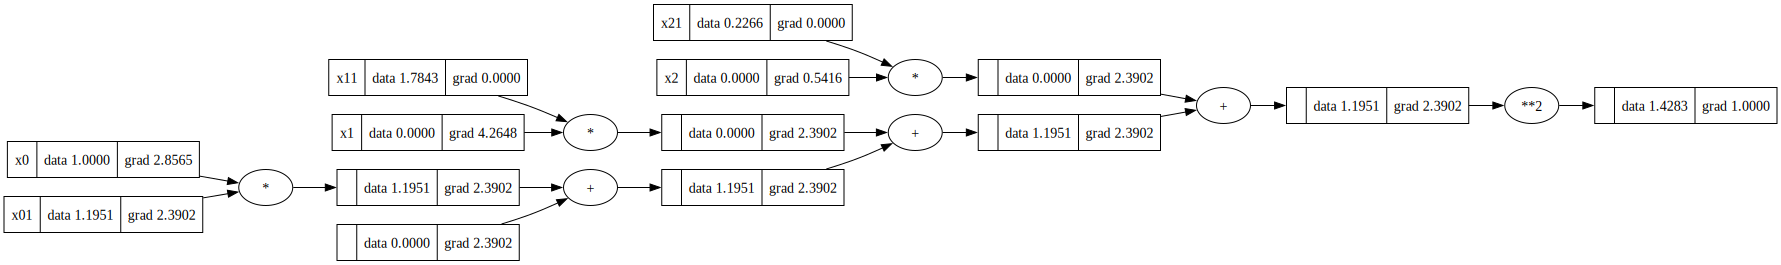

In [24]:
draw_dot(loss)

In [23]:
# for p in w.parameters():
#     p.grad = 0.0

loss.backward()

In [43]:
print([[ weight.grad for weight in weights] for weights in w])

[[0.0, 2.3902, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]


In [49]:
print([[ weight.data for weight in weights] for weights in w])

[[0.2963, -22.730802, 0.7433], [2.6439, 1.7843, 0.2086], [-0.6386, 0.2266, -0.0906]]


In [48]:
for weights in w:
    for weight in weights:
        weight.data += -(.  * weight.grad)